In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [3]:
image_dir_basepath = '../data/images/'
names = ['LarryPage', 'MarkZuckerberg', 'BillGates']
image_size = 160

In [4]:
model_path = '../model/keras/model/facenet_keras.h5'
model = load_model(model_path)

/Users/aleksandrdremov/anaconda3/envs/FaceScrape/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [6]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [21]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        print(np.max(cropped), np.min(cropped))
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [22]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = load_and_align_images(filepaths, margin)
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))
    return embs

In [23]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(prewhiten(imread(data[img_name0]['image_filepath'])))
    plt.subplot(1, 2, 2)
    plt.imshow(prewhiten(imread(data[img_name1]['image_filepath'])))

In [24]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

255 0
255 0
255 0
255 0
245 0
255 0
255 0
255 0
242 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.1686007976531982


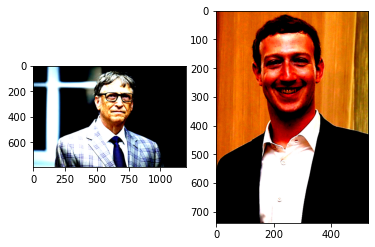

In [25]:
calc_dist_plot('BillGates0', 'MarkZuckerberg1')

0.48112890124320984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


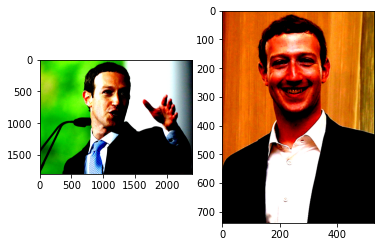

In [26]:
calc_dist_plot('MarkZuckerberg0', 'MarkZuckerberg1')

# plot

In [34]:
X = []
for v in data.values():
    X.append(v['emb'])
pca = PCA(n_components=3).fit(X)

In [35]:
X_BillGates = []
X_LarryPage = []
X_MarkZuckerberg = []
for k, v in data.items():
    if 'Bill' in k:
        X_BillGates.append(v['emb'])
    elif 'Larry' in k:
        X_LarryPage.append(v['emb'])
    elif 'Mark' in k:
        X_MarkZuckerberg.append(v['emb'])
        
Xd_BillGates = pca.transform(X_BillGates)
Xd_LarryPage = pca.transform(X_LarryPage)
Xd_MarkZuckerberg = pca.transform(X_MarkZuckerberg)

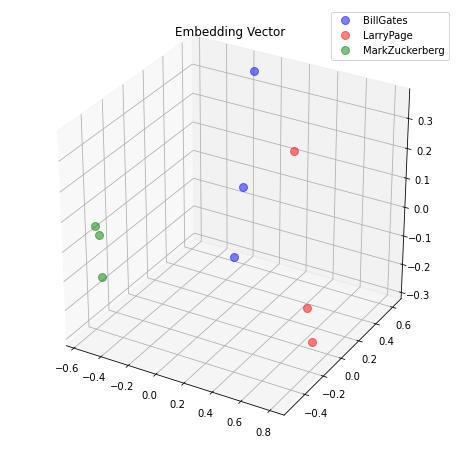

In [36]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(Xd_BillGates[:,0], Xd_BillGates[:,1], Xd_BillGates[:,2],
        'o', markersize=8, color='blue', alpha=0.5, label='BillGates')
ax.plot(Xd_LarryPage[:,0], Xd_LarryPage[:,1], Xd_LarryPage[:,2],
        'o', markersize=8, color='red', alpha=0.5, label='LarryPage')
ax.plot(Xd_MarkZuckerberg[:,0], Xd_MarkZuckerberg[:,1], Xd_MarkZuckerberg[:,2],
        'o', markersize=8, color='green', alpha=0.5, label='MarkZuckerberg')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()